## ARBRE DE DECISION :

X = fonction,code postale, boutique 

y= fréquence de visite 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib.ticker import PercentFormatter
from pandas_ods_reader import read_ods
warnings.filterwarnings('ignore')

#### **Recuperation des dataset**

In [3]:
#Data session d'hiver: 
df_s1= pd.read_excel("etudfinal1.xlsx")
path = "./etudfinal.ods"
df_s2 = read_ods(path)

In [4]:
display(df_s1.shape)
display(df_s2.shape)

(245, 26)

(1191, 27)

In [5]:
#Dropper toutes les colones non necessaire 
df_s2 = df_s2.drop(["de combien de personnes se compose votre foyer ?","14. Dans les grandes évolutions de la consommation, quelles sont les 3 qui vous tiennent le plus à cœur ?","Quel est le dernier produit de la gamme Pariès que vous connaissez ?",'Horodateur', 'unnamed.1','unnamed.2',"S'il y a des enfants dans votre foyer, quel âge ont-ils ?","Si non, confiez-moi votre adresse mail pour recevoir notre actualité (moins de 10 mails par an)"], axis=1)

In [6]:
#Verifier les nouvelles dimensions
display(df_s2.shape)

(1191, 19)

In [7]:
#compter les valeurs uniques par colone 
df_s2.count()

Boutique                                                                                                       1191
code postal                                                                                                    1191
Depuis combien de temps êtes vous un client de la Maison Pariès ?                                              1191
A quelle fréquence venez-vous nous rendre visite ?                                                             1191
Comment nous avez-vous connus ?                                                                                1191
En 2 mots, comment définiriez-vous la Maison ?                                                                 1191
A quelle(s) occasion(s) effectuez-vous des achats chez nous                                                    1191
Quel est le produit que vous préférez ?                                                                        1035
8. Quels sont les produits de nos gammes que vous achetez chez d’autres 

#### **Traitement des variables**

**1. changer les valeurs intervalles d'age en catégorielle:**
  - 65/+  : 5
  - 50/64 : 4
  - 35/49 : 3
  - 25/34 : 2
  - 18/24 : 1
  - 15 ans & 17 ans  : 0

 

In [8]:
#Renomer le nom de la colone
df_s2.rename(columns={"Tranche d\'âge":"Tranche_age"},inplace=True)
#Rajouter la nouvelle colone Age qui sera modifiée
df_s2["Age"]=df_s2["Tranche_age"]

In [9]:
#Remplacement par la methode assign()
dct_age= {"15/17":0, "18/24":1,"25/34":2,"35/49":3,"50/64":4,"65 et +":5}  
df_s2=df_s2.assign(Age=df_s2.Age.map(dct_age))


**2. Remplacer toutes les occurences de gateau basque & chocolat par des values categorielles = "0" & "1"**

In [11]:
#Trouve toutes les occurences et remplace par True ou false
df_s2["Gateau_basque"]= (df_s2["8. Quels sont les produits de nos gammes que vous achetez chez d’autres artisans ?"].str.find("Gateau basque")>=0).astype(int)
df_s2["Chocolat"]=(df_s2["8. Quels sont les produits de nos gammes que vous achetez chez d’autres artisans ?"].str.find("Chocolat")>=0).astype(int)

In [12]:
#Remplace True par (1) & False par (0)
#df_s2["Gateau_basque"] = np.where(df_s2["Gateau_basque"] == "True", 0, 1)
#df_s2["Chocolat"] = np.where(df_s2["Chocolat"] == "True", 0, 1)

**3) Transformer les features & target voulues**
  - fonction : trois catégories (Fonction =1 ou pas de fonction = 0)
  - code 
  - boutique : A(St_jean), B(Bayone), C(Biarritz), D(Socoa), E(Espelette), Bordeaux(F)

In [ ]:
#code postale : 0 = toutes les autres departements & 1 = departement 64
df_s2["code_post"]= (df_s2["code postal"].astype(str).str.find('64',0,2)==0).astype(int)

In [17]:
#Remplacement des noms par des categories 
dct_btik= {"St Jean":"A", "Bayone":"B","Biarritz":"C","Socoa":"D","Espelette":"E","Bordeaux":"F"}  
df_s2=df_s2.assign(Boutique=df_s2.Boutique.map(dct_btik))

In [28]:
df_s2["fonction"]= df_s2[["Quelle est votre catégorie socio-professionnelle ?"]]
#Remplacement des noms par des categories 
dct_fction={"Retraité":0, "Cadre et profession intellectuelle supérieure":1,"Employé":1,
             "Profession libérale ":1,"Etudiant ":0,"Artisan, commerçant, chef d'entreprise":1,
             "Profession intermédiaire":1,"Sans profession":0,"Ouvrier":1,"Agriculteur exploitant":1}  
df_s2=df_s2.assign(fonction=df_s2.fonction.map(dct_fction))

In [29]:
df_s2["fonction"].value_counts()

1.0    657
0.0    341
Name: fonction, dtype: int64

In [31]:
df_s2["A quelle fréquence venez-vous nous rendre visite ?"].value_counts()

visite exceptionnelle                    642
visite mensuelle                         268
C'est la première fois !                 177
visite hebdomadaire                       81
Tous les 15 jours                         14
3 fois par semaine                         2
visite exceptionnelle; Surtout en été      1
Tous les jours                             1
Surtout en été                             1
Surtout l'été; Noël                        1
Surtout l’été                              1
Tous les 2 jours                           1
visite exceptionnelle, Surtout en été      1
Name: A quelle fréquence venez-vous nous rendre visite ?, dtype: int64

In [ ]:
#Remplacement des noms par des categories 
dct_fonction= {"St Jean":"A", "Bayone":"B","Biarritz":"C","Socoa":"D","Espelette":"E","Bordeaux":"F"}  
df_s2=df_s2.assign(Boutique=df_s2.Boutique.map(dct_btik))

In [ ]:
#df_s2['new_col'] = df_s2['code postal'].astype(str).str[0:2]

#### **Decision Trees model**
  - features (X) : Age, code postale, 
  - Target (y): Fidele(1) ou non Fidele(0) 

In [ ]:
y= np.repeat([0,1],len(df_s2.index)/2)
#a = np.array([1,1])
y = np.append(y,1)
y_fturs =pd.DataFrame(y)
#df_s2["y"]=y

In [ ]:
X_fturs=df_s2[["Age","Gateau_basque","Chocolat"]]

In [ ]:
X, y = X_fturs, y_fturs
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

In [ ]:
clf.predict([[3,1,0]])

array([1])

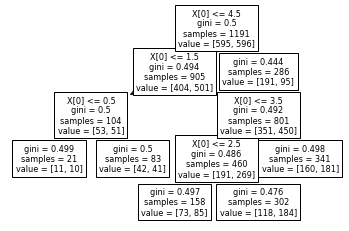

In [ ]:
tree.plot_tree(clf);